# Implement of GCN

## Load Packages

In [1]:
import os
import dgl
import torch
import collections
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from dgl.nn.pytorch import GraphConv

Using backend: pytorch


## Load Train Data

In [ ]:
def label(flag: str) -> int:
    return {
        '-': 0,
        'snmpgetattack': 1,
        'warez': 2,
        'portsweep': 3,
        'nmap': 4,
        'warezclient': 5,
        'ipsweep': 6,
        'dict': 7,
        'neptune': 8,
        'smurf': 9,
        'pod': 10,
        'snmpguess': 11,
        'teardrop': 12,
        'satan': 13,
        'httptunnel-e': 14,
        'ignore': 15,
        'mscan': 16,
        'guest': 17,
        'rootkit': 18,
        'back': 19,
        'apache2': 20,
        'processtable': 21,
        'mailbomb': 22,
        'smurfttl': 23,
        'saint': 24
    }.get(flag[:-1])


def line_split(line: str) -> tuple:
    src_ip, dst_ip, port, time, connect_type = line.split('\t')
    return int(src_ip), int(dst_ip), int(port), int(time), label(connect_type)

# Data File Path

train_set_path = 'data/train'
valid_set_path = 'data/valid_query'
test_set_path = 'data/test_query'

train_set_list = os.listdir(train_set_path)
valid_set_list = os.listdir(valid_set_path)
test_set_path = os.listdir(test_set_path)

file_index = 0

# Features

src_in_degree = collections.OrderedDict()
src_out_degree = collections.OrderedDict()
dst_in_degree = collections.OrderedDict()
dst_out_degree = collections.OrderedDict()

port_num = collections.OrderedDict()
port_list = collections.OrderedDict()
time_len = collections.OrderedDict()
connect_num = collections.OrderedDict()
label_list = collections.OrderedDict()

# Tool Parameters

nodes_origin = []
edges_origin = {}

edges_trans_src = []
edges_trans_dst = []

node_in_degree = {}
node_out_degree = {}

node_in_edges = {}
node_out_edges = {}

edge_src_list = {}
edge_dst_list = {}

# Count Parameters

edge_index = 0

print('Init variables done.')

for file in train_set_list:
    file_index += 1
    if file_index == 114:
        continue
    print('Loading File {}/{}...'.format(file_index, len(train_set_list)), end='\r')
    
    file_path = train_set_path + '/' + file
    data = open(file_path)
    
    for line in data:
        src_ip, dst_ip, port, time, connect_type = line_split(line)

        # Repeat Connections
        if (src_ip, dst_ip) in edges_origin.keys():
            edge_index_temp = edges_origin[(src_ip, dst_ip)]

            # Assign Features
            time_len[edge_index_temp] += time
            connect_num[edge_index_temp] += 1
            label_list[edge_index_temp][connect_type] += 1
            if port in port_list[edge_index_temp]:
                pass
            else:
                port_num[edge_index_temp] += 1
                port_list[edge_index_temp].append(port)

        # New Connections     
        else:
            # Record Origin Node and Edge
            nodes_origin.append(src_ip)
            nodes_origin.append(dst_ip)
            edges_origin[(src_ip, dst_ip)] = edge_index

            # Update Node Parameters
            if src_ip in node_out_degree.keys():
                node_out_degree[src_ip] += 1
            else:
                node_out_degree[src_ip] = 1
            if dst_ip in node_in_degree.keys():
                node_in_degree[dst_ip] += 1
            else:
                node_in_degree[dst_ip] = 1

            # Store Nodes' In-Out Edges
            if src_ip in node_out_edges.keys():
                node_out_edges[src_ip].append(edge_index)
            else:
                node_out_edges[src_ip] = [edge_index]
            if dst_ip in node_in_edges.keys():
                node_in_edges[dst_ip].append(edge_index)
            else:
                node_in_edges[dst_ip] = [edge_index]

            # Update Edge Parameters
            if edge_index in edge_src_list.keys():
                edge_src_list[edge_index].append(src_ip)
            else:
                edge_src_list[edge_index] = [src_ip]
            if edge_index in edge_dst_list.keys():
                edge_dst_list[edge_index].append(dst_ip)
            else:
                edge_dst_list[edge_index] = [dst_ip]

            # Assign Features
            port_num[edge_index] = 1
            port_list[edge_index] = [port]
            time_len[edge_index] = time
            connect_num[edge_index] = 1
            label_list[edge_index] = [0 * x for x in range(25)]
            label_list[edge_index][connect_type] += 1

            edge_index += 1
            
print('Data Loading Done')

# Remove Repeats
nodes_origin = list(set(nodes_origin))
for i in range(len(edge_src_list)):
    edge_src_list[i] = list(set(edge_src_list[i]))
for i in range(len(edge_dst_list)):
    edge_dst_list[i] = list(set(edge_dst_list[i]))
    
# Create Transform Graph
for node in nodes_origin:
    if not node in node_in_edges.keys() or not node in node_out_edges.keys():
        continue
    if not node_in_edges[node] or not node_out_edges[node]:
        continue
    for src_edge in node_in_edges[node]:
        for dst_edge in node_out_edges[node]:
            edges_trans_src.append(src_edge)
            edges_trans_dst.append(dst_edge)
            
print('Data clean up done.')
    
# Create Features
for edge in edge_src_list.keys():
    if edge_src_list[edge][0] not in node_in_degree.keys():
        src_in_degree[edge] = 0
    else:
        src_in_degree[edge] = node_in_degree[edge_src_list[edge][0]]
    if edge_src_list[edge][0] not in node_out_degree.keys():
        src_out_degree[edge] = 0
    else:
        src_out_degree[edge] = node_out_degree[edge_src_list[edge][0]]
    
for edge in edge_dst_list.keys():
    if edge_dst_list[edge][0] not in node_in_degree.keys():
        dst_in_degree[edge] = 0
    else:
        dst_in_degree[edge] = node_in_degree[edge_dst_list[edge][0]]
    if edge_dst_list[edge][0] not in node_out_degree.keys():
        dst_out_degree[edge] = 0
    else:
        dst_out_degree[edge] = node_out_degree[edge_dst_list[edge][0]]
    
print('Feature create done.')
    
src_in_degree_norm = list(src_in_degree.values()) / np.linalg.norm(list(src_in_degree.values()))
src_out_degree_norm = list(src_out_degree.values()) / np.linalg.norm(list(src_out_degree.values()))
dst_in_degree_norm = list(dst_in_degree.values()) / np.linalg.norm(list(dst_in_degree.values()))
dst_out_degree_norm = list(dst_out_degree.values()) / np.linalg.norm(list(dst_out_degree.values()))

port_num_norm = list(port_num.values()) / np.linalg.norm(list(port_num.values()))
time_len_norm = list(time_len.values()) / np.linalg.norm(list(time_len.values()))
connect_num_norm = list(connect_num.values()) / np.linalg.norm(list(connect_num.values()))

print('Normalize done.')

feature_matrix = np.empty([1, 7])
for i in range(len(edges_origin)):
    feature_matrix = np.vstack((feature_matrix, [src_in_degree_norm[i], src_out_degree_norm[i], dst_in_degree_norm[i], dst_out_degree_norm[i], \
                                                 port_num_norm[i], time_len_norm[i], connect_num_norm[i]]))
feature_matrix = np.delete(feature_matrix, obj=0, axis=0)    
feature_matrix = feature_matrix.astype(np.float32)

print('Data process done.')

In [3]:
print('Data Loading Done')

# Remove Repeats
nodes_origin = list(set(nodes_origin))
for i in range(len(edge_src_list)):
    edge_src_list[i] = list(set(edge_src_list[i]))
for i in range(len(edge_dst_list)):
    edge_dst_list[i] = list(set(edge_dst_list[i]))
    
# Create Transform Graph
for node in nodes_origin:
    if not node in node_in_edges.keys() or not node in node_out_edges.keys():
        continue
    if not node_in_edges[node] or not node_out_edges[node]:
        continue
    for src_edge in node_in_edges[node]:
        for dst_edge in node_out_edges[node]:
            edges_trans_src.append(src_edge)
            edges_trans_dst.append(dst_edge)
            
print('Data clean up done.')
    
# Create Features
for edge in edge_src_list.keys():
    if edge_src_list[edge][0] not in node_in_degree.keys():
        src_in_degree[edge] = 0
    else:
        src_in_degree[edge] = node_in_degree[edge_src_list[edge][0]]
    if edge_src_list[edge][0] not in node_out_degree.keys():
        src_out_degree[edge] = 0
    else:
        src_out_degree[edge] = node_out_degree[edge_src_list[edge][0]]
    
for edge in edge_dst_list.keys():
    if edge_dst_list[edge][0] not in node_in_degree.keys():
        dst_in_degree[edge] = 0
    else:
        dst_in_degree[edge] = node_in_degree[edge_dst_list[edge][0]]
    if edge_dst_list[edge][0] not in node_out_degree.keys():
        dst_out_degree[edge] = 0
    else:
        dst_out_degree[edge] = node_out_degree[edge_dst_list[edge][0]]
    
print('Feature create done.')
    
src_in_degree_norm = list(src_in_degree.values()) / np.linalg.norm(list(src_in_degree.values()))
src_out_degree_norm = list(src_out_degree.values()) / np.linalg.norm(list(src_out_degree.values()))
dst_in_degree_norm = list(dst_in_degree.values()) / np.linalg.norm(list(dst_in_degree.values()))
dst_out_degree_norm = list(dst_out_degree.values()) / np.linalg.norm(list(dst_out_degree.values()))

port_num_norm = list(port_num.values()) / np.linalg.norm(list(port_num.values()))
time_len_norm = list(time_len.values()) / np.linalg.norm(list(time_len.values()))
connect_num_norm = list(connect_num.values()) / np.linalg.norm(list(connect_num.values()))

print('Normalize done.')

feature_matrix = np.empty([1, 7])
for i in range(len(edges_origin)):
    feature_matrix = np.vstack((feature_matrix, [src_in_degree_norm[i], src_out_degree_norm[i], dst_in_degree_norm[i], dst_out_degree_norm[i], \
                                                 port_num_norm[i], time_len_norm[i], connect_num_norm[i]]))
feature_matrix = np.delete(feature_matrix, obj=0, axis=0)    
feature_matrix = feature_matrix.astype(np.float32)

print('Data process done.')

Data Loading Done
Data clean up done.
Feature create done.
Normalize done.
Data process done.


## Create Model

In [4]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

## Train Model

In [6]:
g = dgl.DGLGraph()

# Create Nodes and Edges

g.add_nodes(len(edges_origin))
g.add_edges(edges_trans_src, edges_trans_dst)

# Assign Features

g.ndata['src_in_degree'] = torch.tensor(src_in_degree_norm)
g.ndata['src_out_degree'] = torch.tensor(src_out_degree_norm)
g.ndata['dst_in_degree'] = torch.tensor(dst_in_degree_norm)
g.ndata['dst_out_degree'] = torch.tensor(dst_out_degree_norm)
g.ndata['port_num'] = torch.tensor(port_num_norm)
g.ndata['time_len'] = torch.tensor(time_len_norm)
g.ndata['connect_num'] = torch.tensor(connect_num_norm)

g = dgl.add_self_loop(g)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


In [ ]:
net = GCN(7, 16, 25)

inputs = torch.tensor(feature_matrix)
labels = torch.tensor(list(label_list.values()), dtype=torch.float32)

optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
loss_func = nn.MSELoss()

# Recoder
loss_list = []

for epoch in range(3000):
    outputs = net(g, inputs)
    loss = loss_func(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item() / 39899)
    
    if epoch % 100 == 0:
        print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

## Train Model With Accuracy

In [39]:
net = GCN(7, 16, 25)

inputs = torch.tensor(feature_matrix)
labels = torch.tensor(list(label_list.values()), dtype=torch.float32)

optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
loss_func = nn.MSELoss()

# Recoder
loss_list = []
accu_list = []

for epoch in range(500):
    outputs = net(g, inputs)
    
    total_number = 0
    correct_number = 0
    
    outputs_max = np.argmax(outputs.detach().numpy(), axis=1)
    labels_max = np.argmax(labels.detach().numpy(), axis=1)
    
    for i in range(len(outputs_max)):
        if outputs_max[i] == labels_max[i]:
            correct_number += 1
        total_number += 1
    
    loss = loss_func(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item() / 39899)
    accu_list.append(correct_number / total_number)
    
    if epoch % 100 == 0:
        print('Epoch {} | Loss: {:.4f} | Accu: {:.4f}'.format(epoch, loss.item(), correct_number / total_number))

Epoch 0 | Loss: 478193.1562 | Accu: 0.0001
Epoch 100 | Loss: 475976.9375 | Accu: 0.0098
Epoch 200 | Loss: 467546.0938 | Accu: 0.3092
Epoch 300 | Loss: 453021.4688 | Accu: 0.4549
Epoch 400 | Loss: 433190.7500 | Accu: 0.4705


In [40]:
count = {x: 0 for x in range(25)}
for i in range(len(outputs_max)):
    count[outputs_max[i]] += 1
        
print(count)
count = {x: 0 for x in range(25)}

for i in range(len(labels_max)):
    count[labels_max[i]] += 1
    
print(count)

# count_2 = 0
# for i in range(len(labels_max)):
#     if labels_max[i] >= 1:
#         count_2 += 1
        
# print(len(labels_max))
# print(count_2)

# plt.plot(labels_max, 'bo')
# plt.plot()

{0: 34400, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 5499, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0}
{0: 21264, 1: 2, 2: 71, 3: 11, 4: 3, 5: 8, 6: 7251, 7: 8, 8: 5, 9: 10154, 10: 106, 11: 0, 12: 4, 13: 14, 14: 1, 15: 14, 16: 55, 17: 0, 18: 1, 19: 0, 20: 2, 21: 1, 22: 1, 23: 669, 24: 254}


## Show Train Loss

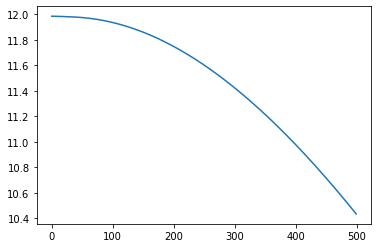

In [21]:
plt.plot(loss_list)
plt.savefig('train-3000-0.1.png')
plt.show()

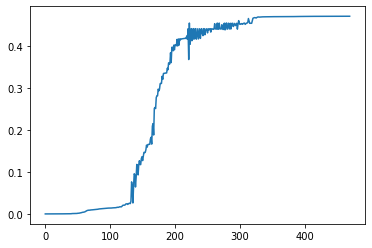

In [24]:
plt.plot(accu_list[30:])
plt.savefig('train-3000-0.1-accu.png')
plt.show()

## Valid Model

### Load Valid Data

In [ ]:
def label(flag: str) -> int:
    return {
        '-': 0,
        'snmpgetattack': 1,
        'warez': 2,
        'portsweep': 3,
        'nmap': 4,
        'warezclient': 5,
        'ipsweep': 6,
        'dict': 7,
        'neptune': 8,
        'smurf': 9,
        'pod': 10,
        'snmpguess': 11,
        'teardrop': 12,
        'satan': 13,
        'httptunnel-e': 14,
        'ignore': 15,
        'mscan': 16,
        'guest': 17,
        'rootkit': 18,
        'back': 19,
        'apache2': 20,
        'processtable': 21,
        'mailbomb': 22,
        'smurfttl': 23,
        'saint': 24
    }.get(flag[:-1])


def line_split(line: str) -> tuple:
    src_ip, dst_ip, port, time = line.split('\t')
    return int(src_ip), int(dst_ip), int(port), int(time)

# Data File Path

train_set_path = 'data/train'
valid_set_path = 'data/valid_query'
test_set_path = 'data/test_query'

train_set_list = os.listdir(train_set_path)
valid_set_list = os.listdir(valid_set_path)
test_set_path = os.listdir(test_set_path)

file_index = 0

# Features

src_in_degree = collections.OrderedDict()
src_out_degree = collections.OrderedDict()
dst_in_degree = collections.OrderedDict()
dst_out_degree = collections.OrderedDict()

port_num = collections.OrderedDict()
port_list = collections.OrderedDict()
time_len = collections.OrderedDict()
connect_num = collections.OrderedDict()
label_list = collections.OrderedDict()

# Tool Parameters

nodes_origin = []
edges_origin = {}

edges_trans_src = []
edges_trans_dst = []

node_in_degree = {}
node_out_degree = {}

node_in_edges = {}
node_out_edges = {}

edge_src_list = {}
edge_dst_list = {}

# Count Parameters

edge_index = 0

print('Init variables done.')

for file in valid_set_list:
    file_index += 1
    if file_index == 114:
        continue
    print('Loading File {}/{}...'.format(file_index, len(train_set_list)), end='\r')
    
    file_path = valid_set_path + '/' + file
    data = open(file_path)
    
    for line in data:
        src_ip, dst_ip, port, time = line_split(line)

        # Repeat Connections
        if (src_ip, dst_ip) in edges_origin.keys():
            edge_index_temp = edges_origin[(src_ip, dst_ip)]

            # Assign Features
            time_len[edge_index_temp] += time
            connect_num[edge_index_temp] += 1
            if port in port_list[edge_index_temp]:
                pass
            else:
                port_num[edge_index_temp] += 1
                port_list[edge_index_temp].append(port)

        # New Connections     
        else:
            # Record Origin Node and Edge
            nodes_origin.append(src_ip)
            nodes_origin.append(dst_ip)
            edges_origin[(src_ip, dst_ip)] = edge_index

            # Update Node Parameters
            if src_ip in node_out_degree.keys():
                node_out_degree[src_ip] += 1
            else:
                node_out_degree[src_ip] = 1
            if dst_ip in node_in_degree.keys():
                node_in_degree[dst_ip] += 1
            else:
                node_in_degree[dst_ip] = 1

            # Store Nodes' In-Out Edges
            if src_ip in node_out_edges.keys():
                node_out_edges[src_ip].append(edge_index)
            else:
                node_out_edges[src_ip] = [edge_index]
            if dst_ip in node_in_edges.keys():
                node_in_edges[dst_ip].append(edge_index)
            else:
                node_in_edges[dst_ip] = [edge_index]

            # Update Edge Parameters
            if edge_index in edge_src_list.keys():
                edge_src_list[edge_index].append(src_ip)
            else:
                edge_src_list[edge_index] = [src_ip]
            if edge_index in edge_dst_list.keys():
                edge_dst_list[edge_index].append(dst_ip)
            else:
                edge_dst_list[edge_index] = [dst_ip]

            # Assign Features
            port_num[edge_index] = 1
            port_list[edge_index] = [port]
            time_len[edge_index] = time
            connect_num[edge_index] = 1

            edge_index += 1
            
print('Data Loading Done')

# Remove Repeats
nodes_origin = list(set(nodes_origin))
for i in range(len(edge_src_list)):
    edge_src_list[i] = list(set(edge_src_list[i]))
for i in range(len(edge_dst_list)):
    edge_dst_list[i] = list(set(edge_dst_list[i]))
    
# Create Transform Graph
for node in nodes_origin:
    if not node in node_in_edges.keys() or not node in node_out_edges.keys():
        continue
    if not node_in_edges[node] or not node_out_edges[node]:
        continue
    for src_edge in node_in_edges[node]:
        for dst_edge in node_out_edges[node]:
            edges_trans_src.append(src_edge)
            edges_trans_dst.append(dst_edge)
            
print('Data clean up done.')
    
# Create Features
for edge in edge_src_list.keys():
    if edge_src_list[edge][0] not in node_in_degree.keys():
        src_in_degree[edge] = 0
    else:
        src_in_degree[edge] = node_in_degree[edge_src_list[edge][0]]
    if edge_src_list[edge][0] not in node_out_degree.keys():
        src_out_degree[edge] = 0
    else:
        src_out_degree[edge] = node_out_degree[edge_src_list[edge][0]]
    
for edge in edge_dst_list.keys():
    if edge_dst_list[edge][0] not in node_in_degree.keys():
        dst_in_degree[edge] = 0
    else:
        dst_in_degree[edge] = node_in_degree[edge_dst_list[edge][0]]
    if edge_dst_list[edge][0] not in node_out_degree.keys():
        dst_out_degree[edge] = 0
    else:
        dst_out_degree[edge] = node_out_degree[edge_dst_list[edge][0]]
    
print('Feature create done.')
    
src_in_degree_norm = list(src_in_degree.values()) / np.linalg.norm(list(src_in_degree.values()))
src_out_degree_norm = list(src_out_degree.values()) / np.linalg.norm(list(src_out_degree.values()))
dst_in_degree_norm = list(dst_in_degree.values()) / np.linalg.norm(list(dst_in_degree.values()))
dst_out_degree_norm = list(dst_out_degree.values()) / np.linalg.norm(list(dst_out_degree.values()))

port_num_norm = list(port_num.values()) / np.linalg.norm(list(port_num.values()))
time_len_norm = list(time_len.values()) / np.linalg.norm(list(time_len.values()))
connect_num_norm = list(connect_num.values()) / np.linalg.norm(list(connect_num.values()))

print('Normalize done.')

feature_matrix = np.empty([1, 7])
for i in range(len(edges_origin)):
    feature_matrix = np.vstack((feature_matrix, [src_in_degree_norm[i], src_out_degree_norm[i], dst_in_degree_norm[i], dst_out_degree_norm[i], \
                                                 port_num_norm[i], time_len_norm[i], connect_num_norm[i]]))
feature_matrix = np.delete(feature_matrix, obj=0, axis=0)    
feature_matrix = feature_matrix.astype(np.float32)

print('Data process done.')

### Test Model

In [ ]:




net = GCN(7, 16, 25)

inputs = torch.tensor(feature_matrix)
labels = torch.tensor(list(label_list.values()), dtype=torch.float32)

optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
loss_func = nn.MSELoss()

# Recoder
loss_list = []

for epoch in range(3000):
    outputs = net(g, inputs)
    loss = loss_func(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item() / 39899)
    
    if epoch % 100 == 0:
        print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

## Test Result on Train Set

In [ ]:
outputs = net(g, inputs)